# Deep Learning Exercise: Transformers

In [ ]:
import torch
from torch import nn
import random
import math
import numpy as np

# Set seed for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Exercise 2: Sentiment analysis using BERT
In this part, you will use the transformer-based model -- BERT to perfrom a ***sentiment analysis*** task based on the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/). <br>

Two important Python libraries will be used in this exercise:

*   [transformers](https://huggingface.co/transformers/): This one provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.
*   [torchtext](https://pytorch.org/text/stable/index.html): The torchtext package consists of data processing utilities and popular datasets for natural language.




In [ ]:
! pip install transformers
! pip install torchtext

## Set up GPU 
Check the availability of the GPU. Make sure you change the runtime type of the colab notebook to enable the use of the GPU. 

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


## Load and preprocess data

We will use the torchtext to load the IMDB dataset.<br>

Please refer to [the document of torchtext](https://https://pytorch.org/text/stable/datasets.html#imdb) for more information. <br>

**Note**: To make the training process less time-consuming, we extract 5000 IMDB reviews for the dataset.

In [ ]:
from torchtext.datasets import IMDB

# get 5000 reviews with their sentiment labels
imdb_data =  list(IMDB(split='train'))
random.shuffle(imdb_data)

imdb_data = imdb_data[:int(0.2*len(imdb_data))]

Create a pandas DataFrame to visualize the dataset

In [ ]:
import pandas as pd

imdb_df = pd.DataFrame(imdb_data, columns=['sentiment', 'review'])

In [ ]:
imdb_df

,sentiment,review
0,pos,I've heard people who say this movie is dull d...
1,pos,Three flash-backs introduce the main character...
2,neg,"OK, how's this for original- this mean, rich o..."
3,neg,"Please, someone stop Ben Stiller from acting i..."
4,neg,For those who like depressing films with sleaz...
...,...,...
4995,pos,Yes it may be goofy and may not seem as funny ...
4996,pos,It should be against the law not to experience...
4997,neg,"As I watch this film, it is interesting to see..."
4998,pos,A 14 year old girl develops her first serious ...


Use [pandas.DataFrame.replace](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html) to convert the categorical values to numerical values for the **sentiment** column in the **imdb_df** DataFrame.


*   pos -> 1
*   neg -> 0




In [ ]:
imdb_df['sentiment'].replace({'pos':1, 'neg':0}, inplace=True)

In [ ]:
imdb_df

,sentiment,review
0,1,I've heard people who say this movie is dull d...
1,1,Three flash-backs introduce the main character...
2,0,"OK, how's this for original- this mean, rich o..."
3,0,"Please, someone stop Ben Stiller from acting i..."
4,0,For those who like depressing films with sleaz...
...,...,...
4995,1,Yes it may be goofy and may not seem as funny ...
4996,1,It should be against the law not to experience...
4997,0,"As I watch this film, it is interesting to see..."
4998,1,A 14 year old girl develops her first serious ...


## Split the dataset to train/test sets

**Note**: The split ratio for train/test is 0.7/0.3

In [ ]:
# get reviews and corresponding sentiments from imdb_df
reviews = imdb_df.review.values
sentiments = imdb_df.sentiment.values

In [ ]:
from sklearn.model_selection import train_test_split

# use the function -- train_test_split to split the reviews and sentiments to get train/test sets

X_train, X_test, Y_train, Y_test = train_test_split(reviews, sentiments, test_size=0.3)


# convert numpy array to list
X_train = X_train.tolist()
X_test = X_test.tolist()

## Preprocess data for the BERT model

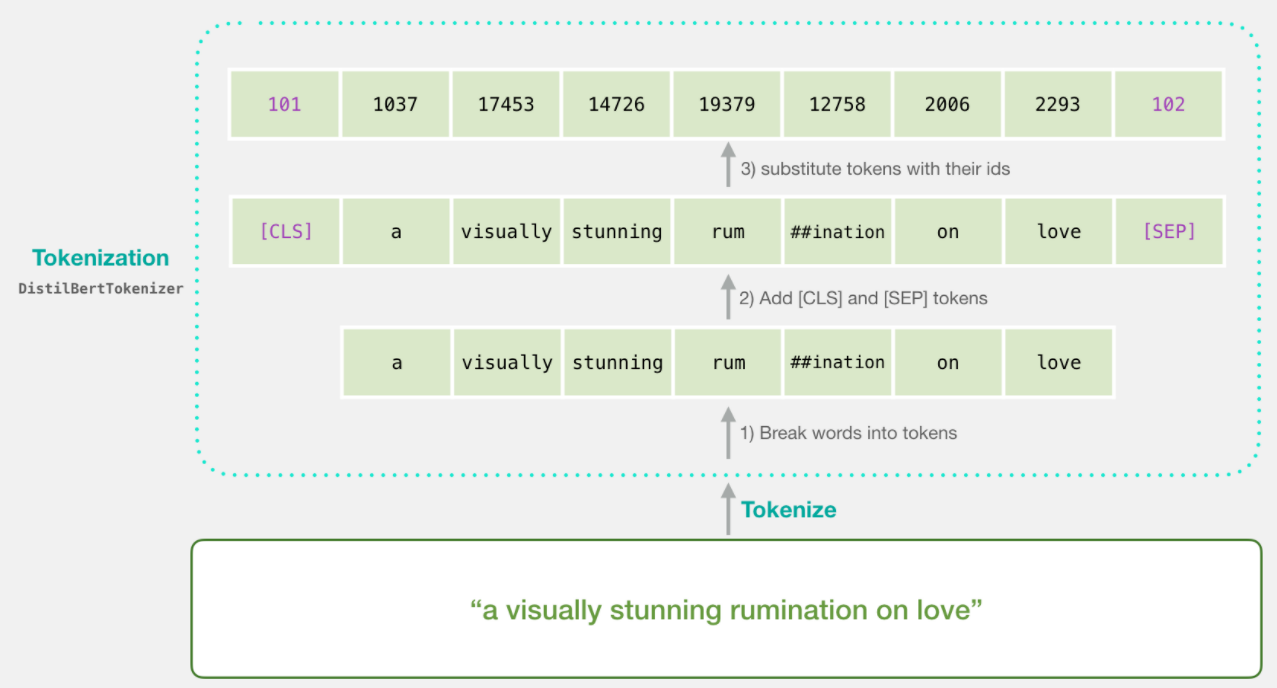

In order to use the pre-trained BERT model, we need to apply the **BERT tokenizer** to process the input sequence. <br>
The reasons are: 

1.   The model has a specific, fixed vocabulary. 
2.   The model uses the WordPiece tokenizer that has a particular way of handling out-of-vocabulary words.

Specifically, for the input sequence, we need to:


1.   add the special token `[CLS]` to the start, and the special token `[SEP]` to the end, for each sequence
2.   pad & truncate all sequences to a single constant length
3.   explicitly specify what are padding tokens with the "attention mask"

More information regarding the BERT tokenizer can be found [here](https://huggingface.co/transformers/tokenizer_summary.html).<br>

The above figure shows an example of how the tokenzier works. 




**Note**: Use `BertTokenizer` to tokenize the text in train and test sets. The output of the tokenizer is a dictionary string to list of ints. The output dictionary contains three keys: `input_ids`, `attention_mask`, and `token_type_ids`.
The `input_ids` are the indices corresponding to each token in our 

*   The `input_ids` are the indices corresponding to each token in our sentence. 
*   The `attention_mask` points out which tokens the model should pay attention to and which ones it should not (since some of the tokens are padding tokens). 
*   The `token_type_ids` indicates to the model which part of the inputs correspond to the first sentence and which part corresponds to the second sentence. In our case, it will have values of all zeros.

Check this [link](https://huggingface.co/transformers/preprocessing.html) to see how to use the tokenizer.


In [ ]:
from transformers import BertTokenizer

# load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# use the tokenizer to tokenize X_train and X_test to get the input_ids, token_type_ids, and attention_mask
# set padding and truncation to True, return_tensors to 'pt', and max_length to 100
# the data type of the tokenizer_output_train and the tokenizer_output_test is dictionary

tokenizer_output_train = tokenizer(X_train, padding=True, truncation=True, max_length=100, return_tensors="pt")
tokenizer_output_test = tokenizer(X_test, padding=True, truncation=True, max_length=100, return_tensors="pt")

In [ ]:
tokenizer_output_train

{'input_ids': tensor([[  101,  1045,  3342,  ...,  3008,  1998,   102],
        [  101,  2003,  2045,  ...,  3459,  1010,   102],
        [  101,  2821,  6203,  ...,  2107,  2004,   102],
        ...,
        [  101,  7929,  1010,  ...,  2000,  2022,   102],
        [  101,  1996,  7577,  ...,  2039,  2037,   102],
        [  101,  2732, 18412,  ...,  5436,  3475,   102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

## Create PyTorch DataLoader

Use the torch [DataLoader](https://pytorch.org/docs/stable/data.html) class to create iterators for the train and test sets. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# convert the data type of the train and test labels to torch.tensor
train_labels = torch.tensor(Y_train)
test_labels = torch.tensor(Y_test)

# set the batch_size for training and testing
train_batch_size = 32
test_batch_size = 64

# create the DataLoader for the train set
train_data = TensorDataset(tokenizer_output_train['input_ids'], tokenizer_output_train['attention_mask'], tokenizer_output_train['token_type_ids'], train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

# create the DataLoader for the test set
test_data = TensorDataset(tokenizer_output_test['input_ids'], tokenizer_output_test['attention_mask'], tokenizer_output_test['token_type_ids'], test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=test_batch_size)

In [ ]:
train_data[1]

(tensor([  101,  2003,  2045,  2505,  4788,  2084,  1037,  4038,  2143,  2008,
         14087,  8562,  1029,  1996,  3437,  2003,  2748,  1025,  2028,  2008,
         11896,  2000,  9699,  2151,  3037,  2802,  1996,  3861,  1012,  1996,
         18458,  2003,  2025,  2205,  2919,  1011,  1037, 15743,  2392,  2158,
          2005,  2019,  6206,  2449,  1011,  2021,  2023,  2003,  1037,  8962,
          5092,  9463,  2099,  2007,  1037,  3532,  5896,  1998,  9000,  1998,
          2074,  2515,  2025,  2147,  1012,  1026,  7987,  1013,  1028,  1026,
          7987,  1013,  1028,  2001,  2023,  2641,  1037,  2204,  1005,  1038,
          1005,  1999,  3758,  1029,  2524,  2000,  5674,  1012,  1996,  2069,
          3893,  7814,  1997,  1996,  3861,  2003,  1996,  3459,  1010,   102]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## Build our BERT model for sentiment analysis

### Create BertClassifier

BERT-base consists of 12 transformer encoder layers, each encoder layer takes in a list of token embeddings, and produces the same number of embeddings with a same hidden size on the output. The output of the final encoder layer of the `[CLS]` token is used to classifiy the input sequence.<br>

We will create a `BertClassifier` class that is based on the `bert-base-uncased` model to use the last hidden layer of the `[CLS] `token and a single-hidden-layer feed-forward neural network as our classifier.


In [ ]:
from transformers import BertModel
bert1 = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert1.config.hidden_size

768

In [ ]:
from transformers import BertModel

# create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for sentiment analysis.
    """
    def __init__(self):
        """
        @param  hidden_size_classifier (int): the hidden size of the classifier
        """
        super(BertClassifier, self).__init__()

        # instantiate the BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # specify hidden size of BERT, hidden size of our classifier, and number of labels
        self.hidden_size_bert = self.bert.config.hidden_size
        self.hidden_size_classifier = 50
        self.num_labels = 2

        # instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size_bert, self.hidden_size_classifier),
            nn.ReLU(),
            nn.Linear(self.hidden_size_classifier, self.num_labels)
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size, max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask information with shape (batch_size, max_length)
        @param    token_type_ids (torch.Tensor): a tensor that hold token type information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids
                            )
        
        # extract the last hidden state of the token `[CLS]` for sentence classification
        last_hidden_state_cls = outputs[0][:, 0, :]

        # feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

### Optimizer and Loss Function



*   For the optimizer, use the [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html). Recommended learning rate : 5e-5, 3e-5 or 2e-5. Recommended eps: 1e-8.
*   For the loss function, use the [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).




In [ ]:
from transformers import AdamW

# instantiate a Bert Classifier
bert_classifier = BertClassifier()

# move the model to device (GPU or CPU)
bert_classifier.to(device)

# create the optimizer
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5, eps=1e-8)

# set the loss function
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Training

The training loop involves the following steps:


*   Unpack our data from the dataloader and load the data onto the GPU
*   Zero out gradients calculated in the previous pass
* Perform a forward pass to compute logits and loss
* Perform a backward pass to compute gradients (`loss.backward()`)
* Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
* Update the model's parameters (`optimizer.step()`)
* Update the learning rate (`scheduler.step()`)



In [ ]:
from transformers import get_linear_schedule_with_warmup
import time

# training loop
def train(dataloader, model, optimizer, criterion, epochs):

  # set the scheduler
  total_steps = len(dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  print('Start training...\n')
  for epoch_i in range(epochs):
    
      # print the header of the result table
      print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Elapsed':^9}")
      print("-"*70)

      # measure the elapsed time of each epoch
      t0_epoch, t0_batch = time.time(), time.time()

      # reset tracking variables at the beginning of each epoch
      total_loss, batch_loss, batch_counts = 0, 0, 0

      # put the model into the training mode
      model.train()

      # for each batch of training data...
      for step, batch in enumerate(train_dataloader):
          batch_counts +=1
          # load batch to device (GPU or CPU)
          b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

          # zero out any previously calculated gradients
          model.zero_grad()

          # perform a forward pass. This will return logits.
          logits = model(b_input_ids, b_attn_mask, b_token_type_ids)

          # compute loss and accumulate the loss values
          loss = criterion(logits, b_labels)
          batch_loss += loss.item()
          total_loss += loss.item()

          # perform a backward pass to calculate gradients
          loss.backward()

          # clip the norm of the gradients to 1.0 to prevent "exploding gradients"
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # update parameters and the learning rate
          optimizer.step()
          scheduler.step()

          # Print the loss values and time elapsed for every 20 batches
          if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
              # Calculate time elapsed for 20 batches
              time_elapsed = time.time() - t0_batch

              # Print training results
              print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

              # Reset batch tracking variables
              batch_loss, batch_counts = 0, 0
              t0_batch = time.time()

      # Calculate the average loss over the entire training data
      avg_train_loss = total_loss / len(train_dataloader)

  print('Training complete')

In [ ]:
train(train_dataloader, bert_classifier, optimizer, criterion, 2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.637636   |   22.91  
   1    |   40    |   0.488785   |   21.77  
   1    |   60    |   0.417887   |   21.74  
   1    |   80    |   0.377466   |   21.74  
   1    |   100   |   0.345481   |   21.72  
   1    |   109   |   0.353327   |   9.22   
 Epoch  |  Batch  |  Train Loss  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.219709   |   22.72  
   2    |   40    |   0.224975   |   21.71  
   2    |   60    |   0.185358   |   21.69  
   2    |   80    |   0.259184   |   21.68  
   2    |   100   |   0.199817   |   21.74  
   2    |   109   |   0.182778   |   9.18   
Training complete


### Evaluation 

The steps for evaluation are:

*   Unpack our data and load onto the GPU
*   Forward pass
*   Compute the f1 score over the test set


In [ ]:
from sklearn.metrics import f1_score

# evaluation 
def evaluate(model, dataloader):
  # put the model into the evaluation mode. The dropout layers are disabled during the test time.
  model.eval()

  # tracking variables
  predictions = []
  labels = []

  # for each batch in our validation set...
  for batch in dataloader:
      # load batch to GPU
      b_input_ids, b_attn_mask, b_token_type_ids, b_labels = tuple(t.to(device) for t in batch)

      # compute logits
      with torch.no_grad():
          logits = model(b_input_ids, b_attn_mask, b_token_type_ids)

      # # compute loss
      # loss = criterion(logits, b_labels)

      # get the predictions
      preds = torch.argmax(logits, dim=1).flatten()
      predictions.append(preds.detach().cpu().numpy())

      # get the labels
      labels.append(b_labels.detach().cpu().numpy())

  # get two lists of predictions and labels with 1d array
  predictions = np.concatenate(predictions, axis=0)
  labels = np.concatenate(labels, axis=0)

  # calc the f1 score
  f1 = f1_score(labels, predictions)

  return f1

In [ ]:
score = evaluate(bert_classifier, test_dataloader)

In [ ]:
print('The f1 score for the test set is {0:4.2f}%'.format(score*100) )

The f1 score for the test set is 84.55%


### Prediction



In [ ]:
# Get one sample from IMDB
instance = list(IMDB(split='test'))[10]

In [ ]:
sentiment, review = instance

In [ ]:
print(f'The review text is: \n {review}')

The review text is: 
 This flick is a waste of time.I expect from an action movie to have more than 2 explosions and some shooting.Van Damme's acting is awful. He never was much of an actor, but here it is worse.He was definitely better in his earlier movies. His screenplay part for the whole movie was probably not more than one page of stupid nonsense one liners.The whole dialog in the film is a disaster, same as the plot.The title "The Shepherd" makes no sense. Why didn't they just call it "Border patrol"? The fighting scenes could have been better, but either they weren't able to afford it, or the fighting choreographer was suffering from lack of ideas.This is a cheap low type of action cinema.


In [ ]:
print(f'The sentiment of the review text is: \n {sentiment}')

The sentiment of the review text is: 
 neg


In [ ]:
# tokenize the review text
output_tokenizer = tokenizer(review)

# convert the tokenizer results to torch.tensor and send to the device(GPU)
p_input_ids = torch.tensor(output_tokenizer['input_ids']).unsqueeze(0).to(device)
p_attention_mask = torch.tensor(output_tokenizer['attention_mask']).unsqueeze(0).to(device)
p_token_type_ids = torch.tensor(output_tokenizer['token_type_ids']).unsqueeze(0).to(device)

# get the model output
logits = bert_classifier(p_input_ids, p_attention_mask, p_token_type_ids)
prediction = torch.argmax(logits, dim=1).flatten()

# get the label
prediction = 'neg' if prediction==0 else 'pos'
print(f'The predicted sentiment is {prediction}, the true sentiment is {sentiment}.')

The predicted sentiment is neg, the true sentiment is neg.


# Exercise 3: Visualize Attention in the BERT model

Use **[BertViz](https://github.com/jessevig/bertviz)** to visualize the attention patterns produced by one or more attention heads in a BERT layer.

In [ ]:
!pip install bertviz

In [ ]:
from bertviz import head_view

# Load model and retrieve attention
model_version = 'bert-base-uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = "The cat sat on the mat"
sentence_b = "The cat lay on the rug"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>